# This notebook makes a conscise result summary for all EMBL matrices, poiting out matrix-obscured ions (see our definition in code)

In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

In [2]:
def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df

In [3]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_14Jul2022.csv"

p_images = p_root_dir / r"4_model_application\model_application_best_replicates"

p_out = p_root_dir / "6_plots" / "matrix_obscured"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'EMBL']]


# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

In [5]:
# Load classification
classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = classes[['name_short', 'main_coarse_class']].drop_duplicates()
chem_subclass = classes[['name_short', 'coarse_class', 'fine_class']]

In [6]:
# Define detected ions as 1, undetected ions as 0 and matrix obscured ions as -1 (later rename in sheets)
df['is_detected'] = 0
threshold=0.8
df.loc[df.pred_val >= threshold, 'is_detected'] = 1

# Here is the definition of a matrix-obscured ion, chosen after visual inspection below
df.loc[(df.pred_val < threshold)
            & (df.intensity_vs_far_bg_ratio > 0.95) 
            & (df.occupancy_vs_far_bg_ratio > 0.95)
            & (df.bg_occupancy > 0.4), 'is_detected'] = -1

In [7]:
metabolite_data = filter_neutral_losses(df, neutral_losses=[""]).pivot_table(index=['name_short', 'adduct'],
                                                                            columns=['Matrix short'],
                                                                            values='is_detected',
                                                                            fill_value=0
                                                                            ).reset_index()

metabolite_data.adduct = pd.Categorical(metabolite_data.adduct, ['+H', '+Na', '+K', '[M]+', '-H', '+Cl', '[M]-'])
metabolite_data.sort_values(by=['name_short', 'adduct'], inplace=True)
table = metabolite_data.replace({1: 'V', 0: '-', -1:'X'})
table.to_csv(p_out / 'metabolite_detectability_EMBL.csv', index=False)

- Make similar table with log10 intensities

In [8]:
df['detected_intensity'] = df.is_detected
df.detected_intensity[df.is_detected==1] = df.spot_intensity_bgr_corrected[df.is_detected==1]

<ipython-input-8-0e383d8629b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.detected_intensity[df.is_detected==1] = df.spot_intensity_bgr_corrected[df.is_detected==1]


In [9]:
intensity_data = filter_neutral_losses(df, neutral_losses=[""]).pivot_table(index=['name_short', 'adduct'],
                                                                            columns=['Matrix short'],
                                                                            values='detected_intensity',
                                                                            fill_value=0
                                                                            ).reset_index()

intensity_data.adduct = pd.Categorical(intensity_data.adduct, ['+H', '+Na', '+K', '[M]+', '-H', '+Cl', '[M]-'])
intensity_data.sort_values(by=['name_short', 'adduct'], inplace=True)
intensity_data.replace({0: '-', -1:'X'}, inplace=True)
intensity_data.to_csv(p_out / 'metabolite_detectability_w_intensities_EMBL.csv', index=False)

- Make a plot to show how many obscured ions there are per chemical class, matrix, and polarity

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


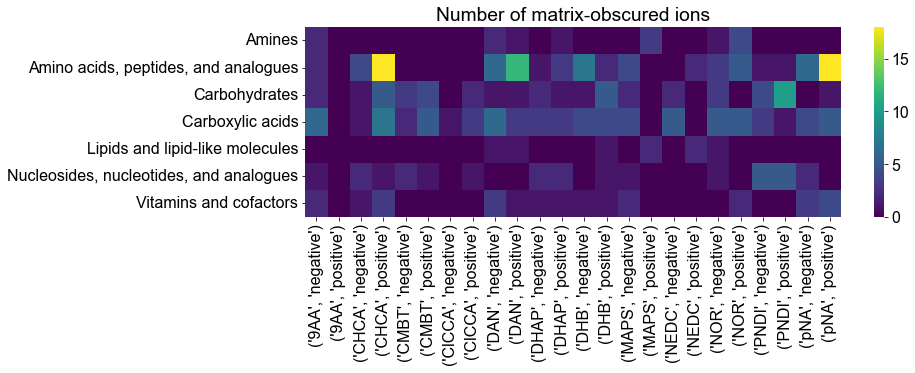

In [10]:
molecule_data = filter_neutral_losses(df, neutral_losses=[""]).pivot_table(index='name_short',
                                                                           columns=['Matrix short', 'Polarity'],
                                                                           values='is_detected',
                                                                           aggfunc= lambda x: sum(x==-1),
                                                                           fill_value=0
                                                                           )

mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

fig, ax = plt.subplots(figsize=(12, 3.5))
plot_data = mapped_data.groupby('main_coarse_class').agg(sum)

h = sns.heatmap(plot_data, cmap='viridis', xticklabels=True, yticklabels=True)
h.set(ylabel = '', title='Number of matrix-obscured ions')
h.figure.savefig(p_out / f"Matrix_obscured_ions_per_coarse_class.png")
h.figure.savefig(p_out / f"Matrix_obscured_ions_per_coarse_class.pdf")

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


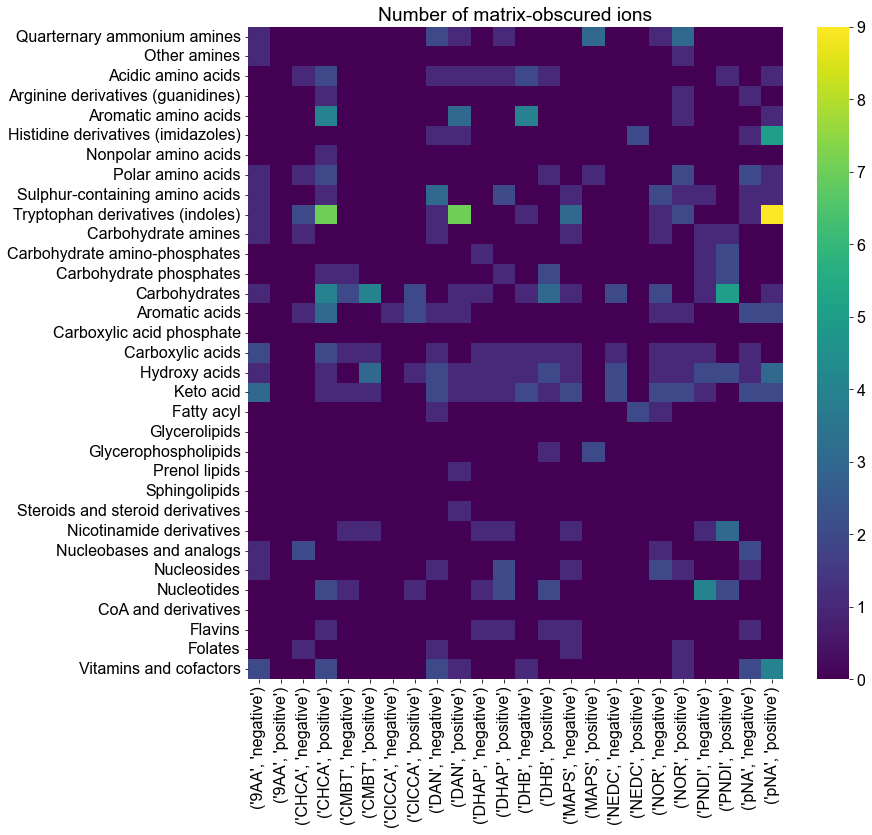

In [11]:
mapped_data_fine = molecule_data.merge(chem_subclass, on='name_short', how='left')

OY_order = ['Quarternary ammonium amines', 'Other amines',
       'Acidic amino acids', 'Arginine derivatives (guanidines)',
       'Aromatic amino acids', 'Histidine derivatives (imidazoles)',
       'Nonpolar amino acids', 'Polar amino acids',
       'Sulphur-containing amino acids',
       'Tryptophan derivatives (indoles)', 'Carbohydrate amines',
       'Carbohydrate amino-phosphates', 'Carbohydrate phosphates',
       'Carbohydrates', 'Aromatic acids', 'Carboxylic acid phosphate',
       'Carboxylic acids', 'Hydroxy acids', 'Keto acid', 'Fatty acyl',
       'Glycerolipids', 'Glycerophospholipids', 'Prenol lipids',
       'Sphingolipids', 'Steroids and steroid derivatives',
       'Nicotinamide derivatives', 'Nucleobases and analogs',
       'Nucleosides', 'Nucleotides', 'CoA and derivatives', 'Flavins',
       'Folates', 'Vitamins and cofactors']

mapped_data_fine['fine_class'] = pd.Categorical(mapped_data_fine['fine_class'], OY_order)

plot_data_fine = mapped_data_fine.groupby('fine_class').agg(sum)

fig, ax = plt.subplots(figsize=(12,12))
f = sns.heatmap(plot_data_fine, cmap='viridis', xticklabels=True, yticklabels=True, ax=ax)
f.set(ylabel = '', title='Number of matrix-obscured ions')
f.figure.savefig(p_out / f"Matrix_obscured_ions_per_fine_class.png")
f.figure.savefig(p_out / f"Matrix_obscured_ions_per_fine_class.pdf")

### Validation for the choice of metrics to define matrix-obscured ions

In [12]:
def clip(img, bottom=0, top=99):
    """Remove bottom and top percentiles of image pixels"""
    lo = np.min(img)
    lo_thresh = np.max(img) / 256
    hi = np.percentile(img[img >= lo_thresh], top)
    img_clipped = np.clip(img, lo, hi)
    return img_clipped

def rescale(data, bottom=0, top=255):
    """Rescale data to lie between [min, max] values"""
    compressed = (data - np.min(data)) / np.max(data - np.min(data))
    rescaled = compressed * (top - bottom) + bottom
    return rescaled

def show_images(images, cols = 1, titles = None): # This function is not my code 
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.viridis()
        plt.imshow(rescale(clip(image)))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [13]:
# Get images
all_images = []
for ds in p_images.rglob("*.hdf5"):
    images = pd.read_hdf(ds).set_index(['dataset_id', 'formula', 'adduct', 'neutral_loss'])    
    all_images.append(images)
    
df_images = pd.concat(all_images)

In [15]:
# undetected ions that are matrix obscured
subset = df.loc[(df.pred_val<0.8)
            & (df.intensity_vs_far_bg_ratio > 0.95) 
            & (df.occupancy_vs_far_bg_ratio > 0.95)
            & (df.bg_occupancy > 0.4)
                   ]
print(len(subset))

subset.set_index(['dataset_id', 'formula', 'adduct', 'neutral_loss'], inplace=True)

2668


Text(0.5, 1.0, 'Not-detected ions')

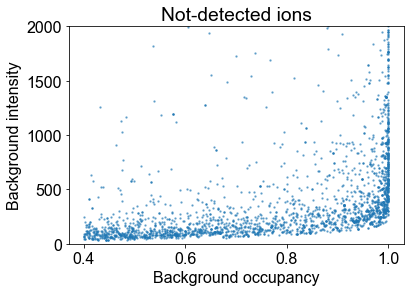

In [16]:
y = subset.bg_intensity
x = subset.bg_occupancy
plt.scatter(x,y, s=2, alpha=0.5)
plt.ylim([0, 2000])
plt.ylabel('Background intensity')
plt.xlabel('Background occupancy')
plt.title('Not-detected ions')

(0.0, 2000.0)

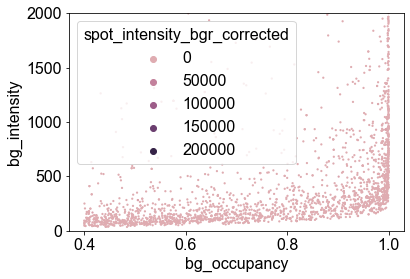

In [17]:
sns.scatterplot(data=subset,
               y='bg_intensity',
               x='bg_occupancy',
               linewidth=0,
               s=5,
               hue='spot_intensity_bgr_corrected')
plt.ylim([0, 2000])

<ipython-input-12-6f0827121204>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


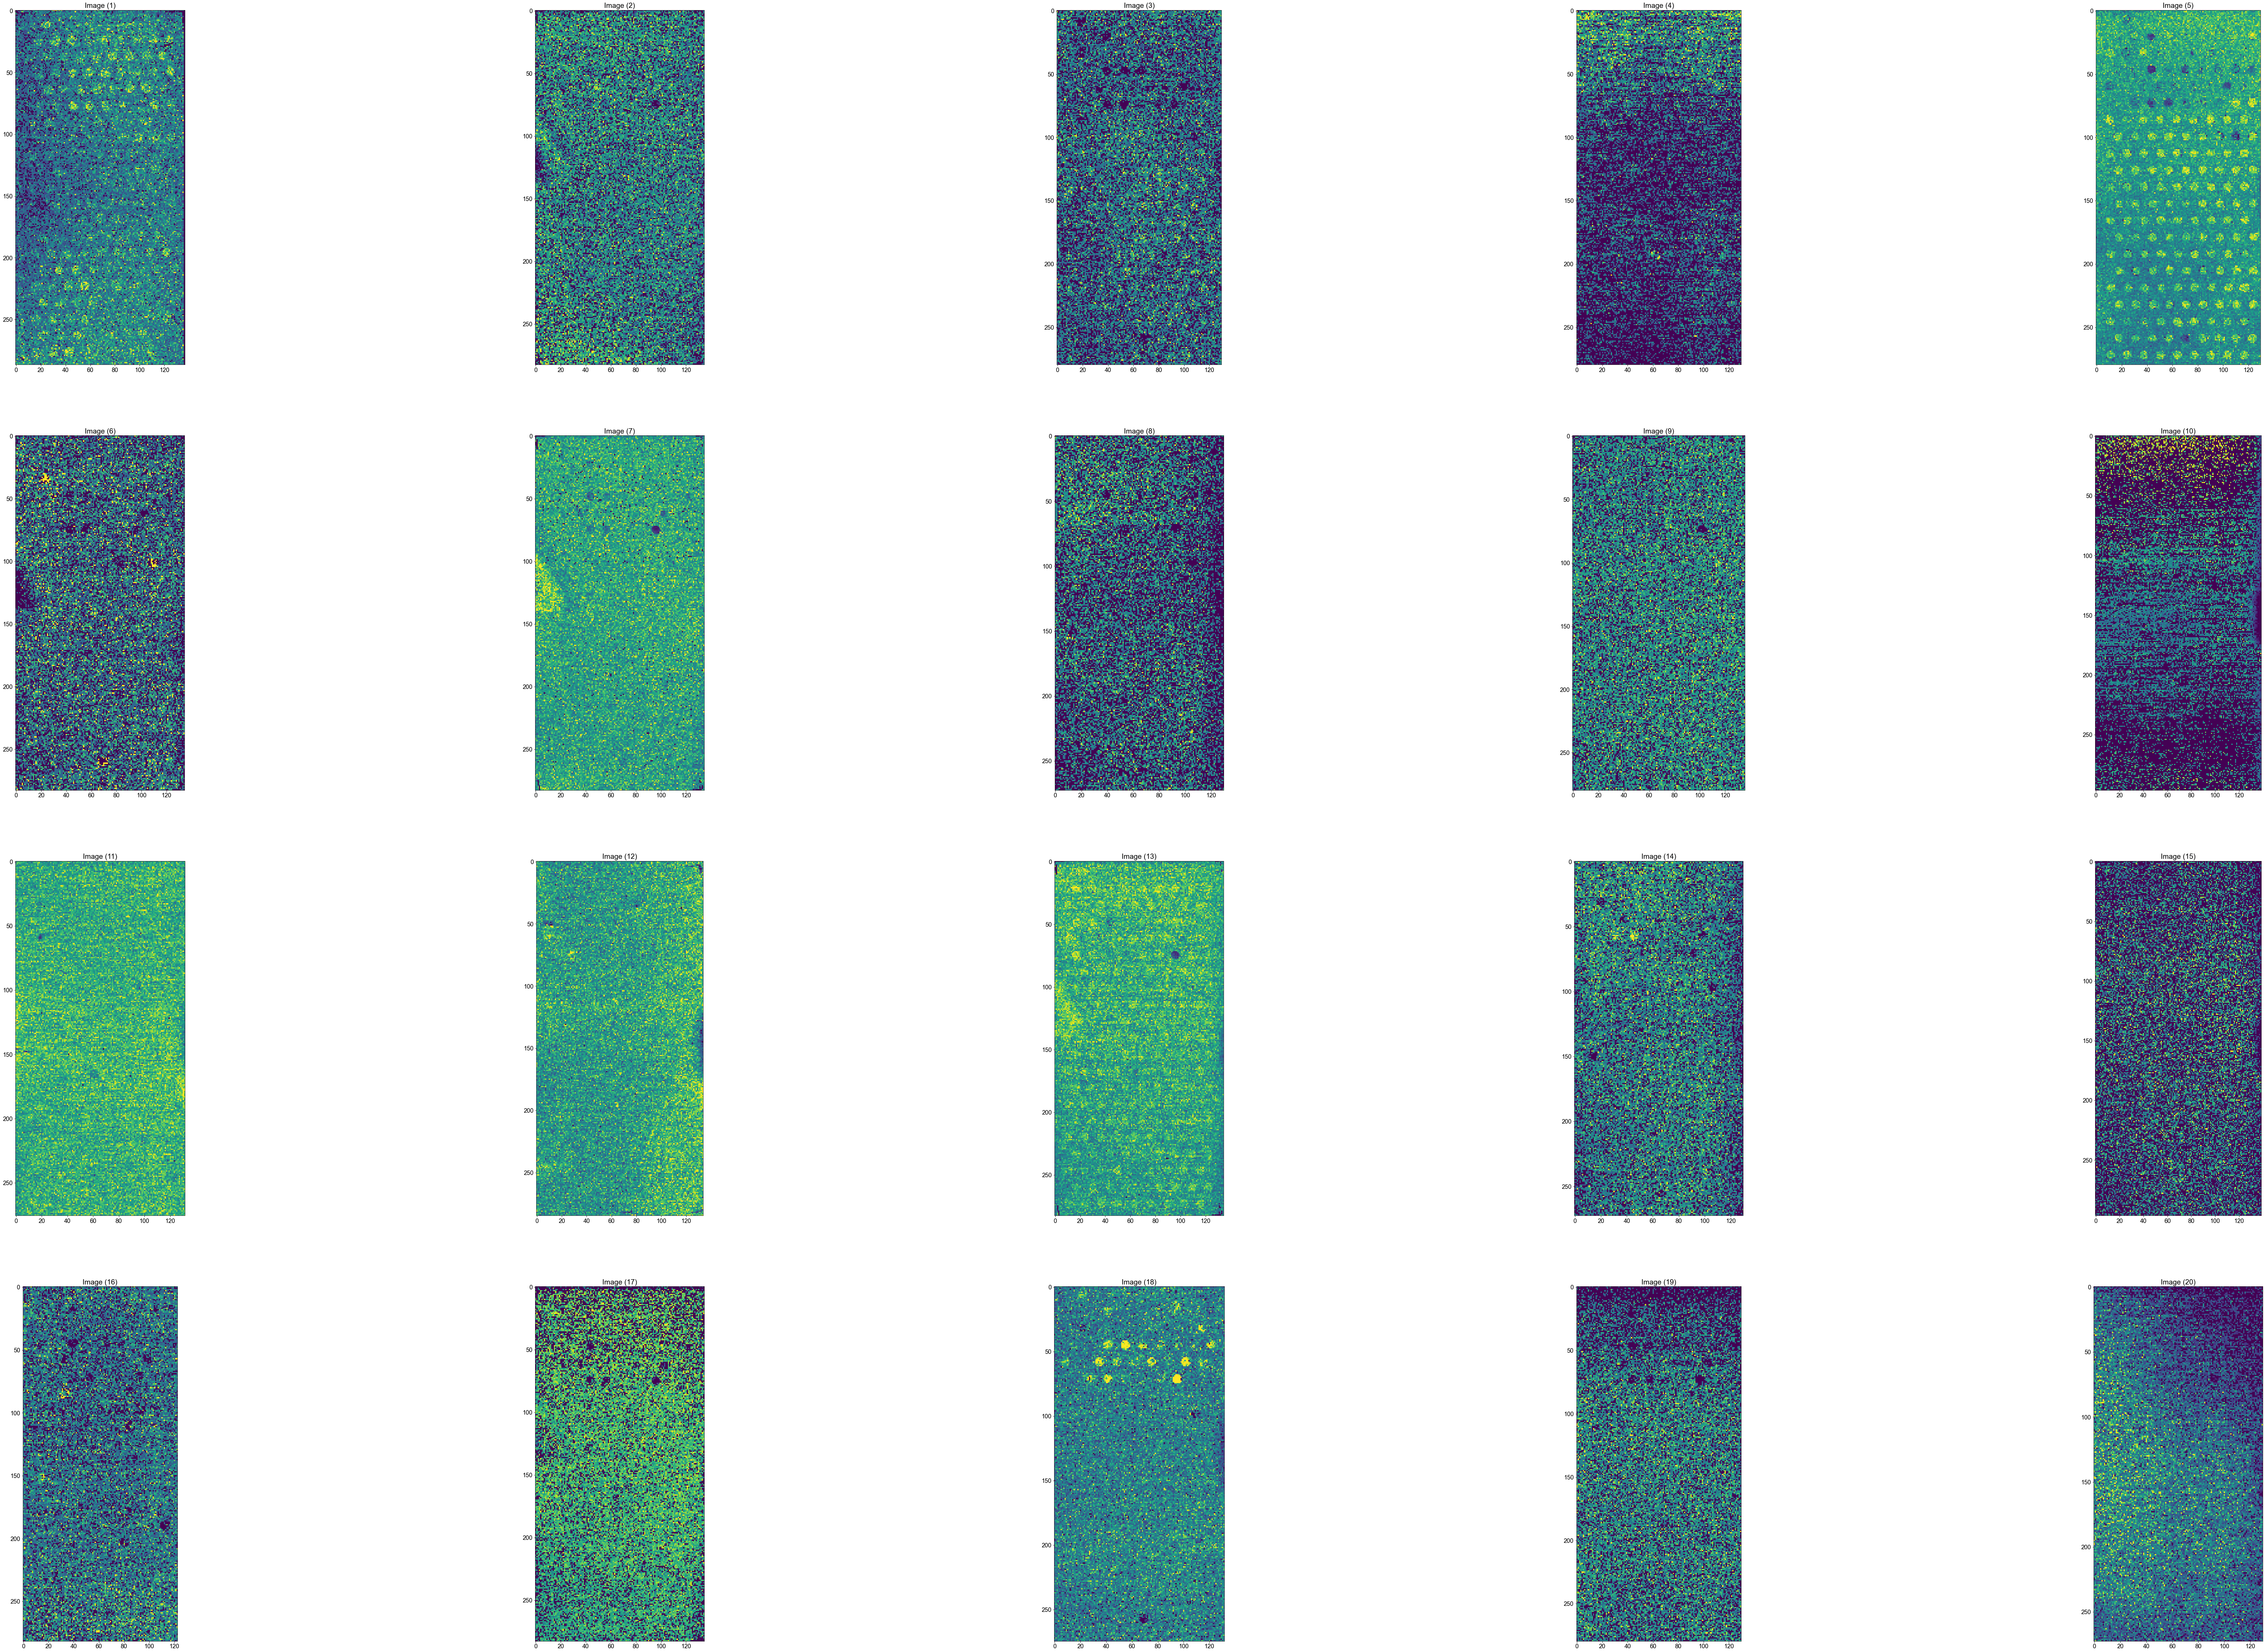

In [18]:
picks = random.sample(subset.index.tolist(), 20)

data = []
for i in picks:
    img = df_images.loc[i, 'image']
    data.append(img)
    
show_images(data, cols = 4)